<a href="https://colab.research.google.com/github/ester0926/Deep-Generative-Models/blob/main/%E4%BD%9C%E6%A5%AD1_%E4%BD%BF%E7%94%A8%E8%AE%8A%E5%88%86%E8%87%AA%E7%B7%A8%E7%A2%BC%E5%99%A8%EF%BC%88VAE%EF%BC%89%E9%87%8D%E5%BB%BA_MNIST_%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-09-19 00:55:46--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.23.113, 74.125.23.138, 74.125.23.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.23.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-09-19 00:55:46--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.204.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  77.9MB/s    in 0.3s    

2025-09-19 00:55:49 (

使用裝置: cpu
開始訓練 VAE...
訓練 Epoch: 1 [0/60000 (0%)]	損失: 544.616455
訓練 Epoch: 1 [12800/60000 (21%)]	損失: 193.897125
訓練 Epoch: 1 [25600/60000 (43%)]	損失: 176.354538
訓練 Epoch: 1 [38400/60000 (64%)]	損失: 149.126007
訓練 Epoch: 1 [51200/60000 (85%)]	損失: 138.983490
====> Epoch: 1 平均損失: 173.6175
====> 測試集損失: 133.4733
訓練 Epoch: 2 [0/60000 (0%)]	損失: 133.804092
訓練 Epoch: 2 [12800/60000 (21%)]	損失: 126.715164
訓練 Epoch: 2 [25600/60000 (43%)]	損失: 126.226593
訓練 Epoch: 2 [38400/60000 (64%)]	損失: 125.249039
訓練 Epoch: 2 [51200/60000 (85%)]	損失: 122.492630
====> Epoch: 2 平均損失: 126.4517
====> 測試集損失: 120.8383
訓練 Epoch: 3 [0/60000 (0%)]	損失: 125.428757
訓練 Epoch: 3 [12800/60000 (21%)]	損失: 118.443893
訓練 Epoch: 3 [25600/60000 (43%)]	損失: 117.100273
訓練 Epoch: 3 [38400/60000 (64%)]	損失: 119.120850
訓練 Epoch: 3 [51200/60000 (85%)]	損失: 118.709320
====> Epoch: 3 平均損失: 118.1945
====> 測試集損失: 114.7856
訓練 Epoch: 4 [0/60000 (0%)]	損失: 114.042770
訓練 Epoch: 4 [12800/60000 (21%)]	損失: 111.625000
訓練 Epoch: 4 [25600/60000 (43%)]	損失: 123.073

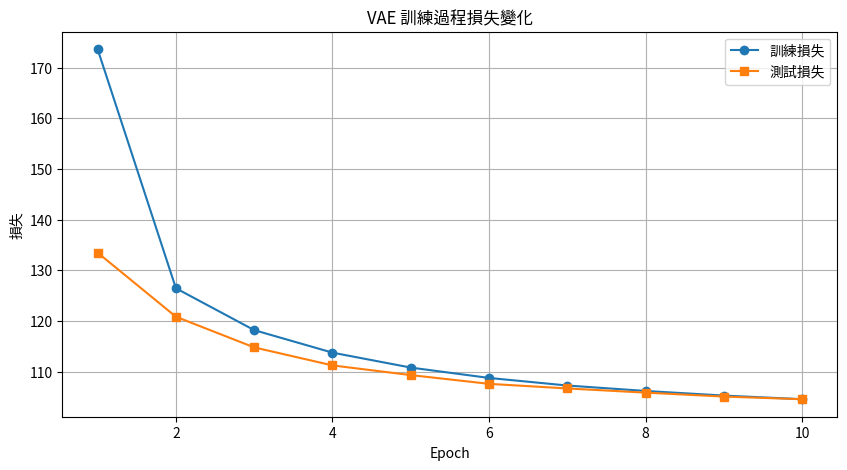

生成重建結果圖...


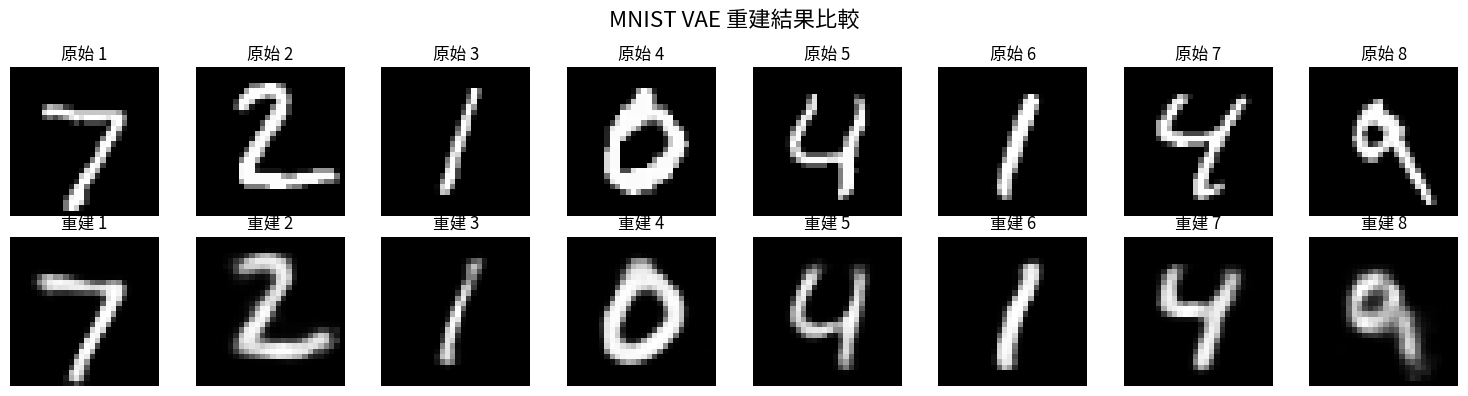

生成新圖像...


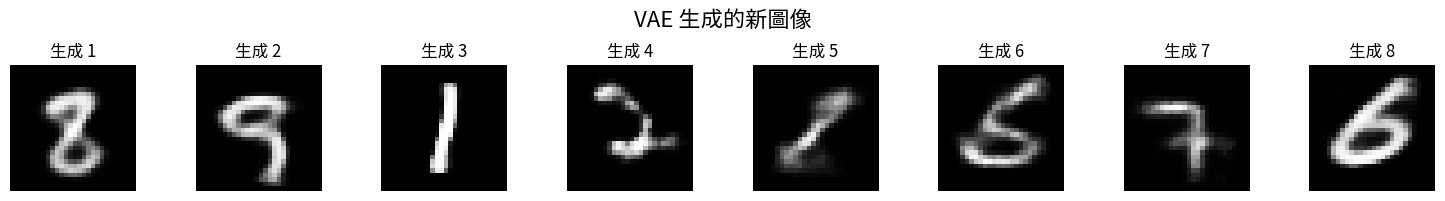

所有結果已保存為圖片檔案!

=== 訓練結果摘要 ===
Epoch 1, Average loss: 173.6175
Epoch 2, Average loss: 126.4517
Epoch 3, Average loss: 118.1945
Epoch 4, Average loss: 113.7515
Epoch 5, Average loss: 110.8071
Epoch 6, Average loss: 108.7598
Epoch 7, Average loss: 107.2655
Epoch 8, Average loss: 106.1917
Epoch 9, Average loss: 105.2826
Epoch 10, Average loss: 104.5664
已儲存重建圖像: reconstruction.png
已儲存生成圖像: generated.png
已儲存損失曲線: loss_curve.png


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 解決 OpenMP 警告
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用裝置: {device}')

# 超參數設定
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 10
LATENT_DIM = 20  # 潛在空間維度

# 資料預處理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # 展平為 784 維向量
])

# 載入 MNIST 資料集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class VAE(nn.Module):
    def __init__(self, input_dim=784, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # 潛在空間的均值和對數方差
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # 輸出範圍 [0, 1]
        )

    def encode(self, x):
        """編碼器：將輸入編碼為潛在空間的均值和對數方差"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """重參數化技巧：從正態分布中採樣"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """解碼器：將潛在變數解碼為重建圖像"""
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    """VAE 損失函數：重建損失 + KL 散度"""
    # 重建損失（二元交叉熵）
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL 散度損失
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

# 初始化模型、優化器
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 訓練函數
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'訓練 Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t損失: {loss.item() / len(data):.6f}')

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} 平均損失: {avg_loss:.4f}')
    return avg_loss

# 測試函數
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'====> 測試集損失: {test_loss:.4f}')
    return test_loss

# 視覺化重建結果
def visualize_reconstruction():
    model.eval()
    with torch.no_grad():
        # 從測試集取一批資料
        data, _ = next(iter(test_loader))
        data = data.to(device)

        # 重建圖像
        recon_batch, _, _ = model(data)

        # 轉換回 28x28 格式
        data = data.view(-1, 28, 28)
        recon_batch = recon_batch.view(-1, 28, 28)

        # 顯示前8個圖像的比較
        fig, axes = plt.subplots(2, 8, figsize=(15, 4))
        fig.suptitle('MNIST VAE 重建結果比較', fontsize=16)

        for i in range(8):
            # 原始圖像
            axes[0, i].imshow(data[i].cpu().numpy(), cmap='gray')
            axes[0, i].set_title(f'原始 {i+1}')
            axes[0, i].axis('off')

            # 重建圖像
            axes[1, i].imshow(recon_batch[i].cpu().numpy(), cmap='gray')
            axes[1, i].set_title(f'重建 {i+1}')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.savefig('reconstruction.png', dpi=150, bbox_inches='tight')
        plt.show()

# 生成新圖像
def generate_images():
    model.eval()
    with torch.no_grad():
        # 從標準正態分布中採樣
        z = torch.randn(8, LATENT_DIM).to(device)
        generated = model.decode(z).view(-1, 28, 28)

        fig, axes = plt.subplots(1, 8, figsize=(15, 2))
        fig.suptitle('VAE 生成的新圖像', fontsize=16)

        for i in range(8):
            axes[i].imshow(generated[i].cpu().numpy(), cmap='gray')
            axes[i].set_title(f'生成 {i+1}')
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig('generated.png', dpi=150, bbox_inches='tight')
        plt.show()

# 主要訓練流程
print("開始訓練 VAE...")
train_losses = []
test_losses = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(epoch)
    test_loss = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

print("訓練完成!")

# 繪製損失曲線
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='訓練損失', marker='o')
plt.plot(range(1, EPOCHS + 1), test_losses, label='測試損失', marker='s')
plt.xlabel('Epoch')
plt.ylabel('損失')
plt.title('VAE 訓練過程損失變化')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# 視覺化結果
print("生成重建結果圖...")
visualize_reconstruction()

print("生成新圖像...")
generate_images()

print("所有結果已保存為圖片檔案!")

# 印出最終結果摘要
print("\n=== 訓練結果摘要 ===")
for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}, Average loss: {train_losses[epoch-1]:.4f}")
print("已儲存重建圖像: reconstruction.png")
print("已儲存生成圖像: generated.png")
print("已儲存損失曲線: loss_curve.png")